# Size Structure distribution

This notebook explores the possibility of parameterizing the size distribution of plankton by the number of plankton in a specific mass range and the total biomass. To do so, we need to import several python libraries.

In [1]:
import numpy as np

from scipy import optimize

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

## Starting Point

A common assumption to make is that the relationship between the size of plankton and its abundance is log-linear. We state that explicitly by defining *x* to be the equivalent spherical diameter (ESD, units: m) and *n(x)* to be abundance (units: count per length, where length refers to bin length not phytoplankton ESD):

$$
n(x) = n_0\left(\frac{x}{x_0}\right)^{-\beta}
$$

Where $n_0$ is the abundance at a given size $x_0$ and $-\beta$ defines the slope in the log-linear relationship (the $-$ is included because larger plankton are less abundant and it is useful for $\beta>0$).

More on specifying $x_0$ later, but we will see that there is a natural choice given our application.

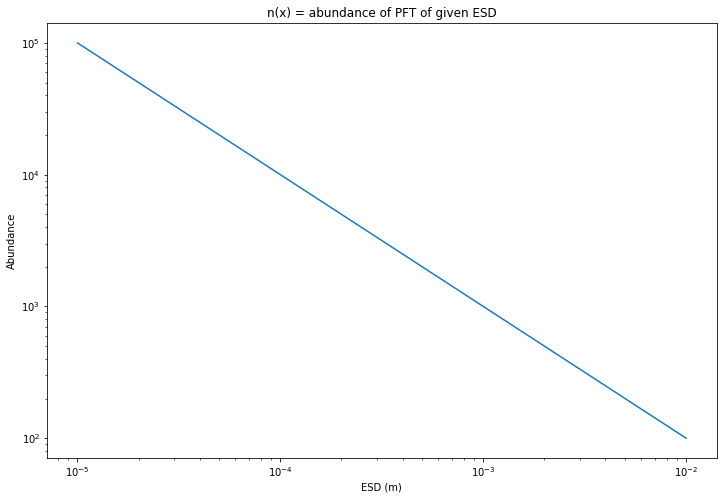

In [2]:
# x is Plankton ESD (in meters); 10 um -> 1 cm seems like a reasonable range
x = 10**(np.linspace(-5, -2, num=100))

def n(x):
    x0 = 1
    n0 = 1
    beta = 1
    return n0 * (x/x0)**-beta

plt.loglog(x, n(x));
plt.title('n(x) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

# We will redefine n [permanently] later in the notebook
del n

We also know that there is a power law relating plankton ESD and plankton mass. Defining the mass to be $m$ (units: kg), we state that relationship as

$$
m(x) = Cx^\alpha
$$

Although we prefer to write it as

$$
m(x) = C_m\left(\frac{x}{x_0}\right)^\alpha
$$

From Rodriguez and Mullin (1986), we see that $C = 10^{-1.2}$ (~0.63) and $\alpha = 2.23$; $C_m = 10^{-1.2}x_0^{2.23}$ but we still have not defined $x_0$. (Note that in RM86 the units of $m$ and $x$ are micrograms C and microns, respectively; changing units results in a different $C$ but keeps $\alpha$ constant).

4.46683592151e-13


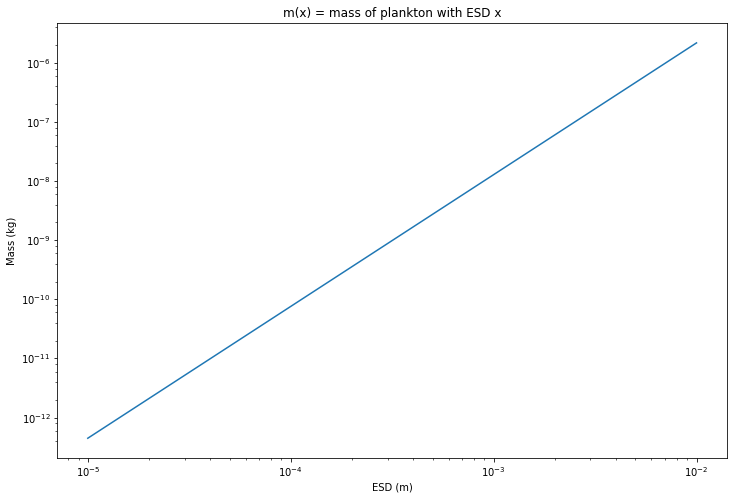

In [3]:
# x is Plankton ESD (in meters); 10 um -> 1 cm seems like a reasonable range
x = 10**(np.linspace(-5, -2, num=100))

def m(x):
    C = 10**-1.2
    alpha = 2.23
    return C * (x**alpha)

plt.loglog(x, m(x));
print m(10**-5)
plt.title('m(x) = mass of plankton with ESD x'); plt.xlabel('ESD (m)'); plt.ylabel('Mass (kg)');

# We will redefine n [permanently] later in the notebook
del m

## Getting to the Parameterization

It should be pointed out that, for a size range $[x_i, x_f]$ the total plankton count is

$$
N = \int_{x_i}^{x_f} n(x)dx
$$

and the total plankton mass is

$$
M = \int_{x_i}^{x_f} n(x)m(x)dx
$$

So if we know $C_m$, $\alpha$, and $x_0$ then we can define plankton count and mass for a size range $[x_i, x_f]$ as a function of $n_0$ and $\beta$:

In [4]:
# power_int returns definite integral from 'xi' to 'xf' of x^y dx
def power_int(y, **kwargs):
    if (y == -1):
        return np.log(kwargs['xf']) - np.log(kwargs['xi'])
    return (kwargs['xf']**(y+1.) - kwargs['xi']**(y+1.))/(y+1.)
# vpower_int is a vectorized version of power_int, it was cleaner than using the "np.where()" operator in power_int()
vpower_int = np.vectorize(power_int)

# N returns total count for plankton with ESD between 'xi' and 'xf'
def N(n0,beta, **kwargs):
    return n0*(kwargs['x0']**beta)*vpower_int(-beta,**kwargs)

# M returns total mass of plankton with ESD between 'xi' and 'xf'
def M(n0,beta, **kwargs):
    return (n0*kwargs['cm']*(kwargs['x0']**(beta-kwargs['alpha'])) * 
            vpower_int(kwargs['alpha']-beta,**kwargs))

To see if this function is invertible, we look at contours of $N$ and $M$ over reasonable ranges of $(n_0, \beta)$-space for some realistic choices of the parameters $C_m$, $\alpha$, $x_0$, $x_i$, and $x_f$.

## Defining $x_0$

coming soon? I think we want $x_0 = x_f$, though...

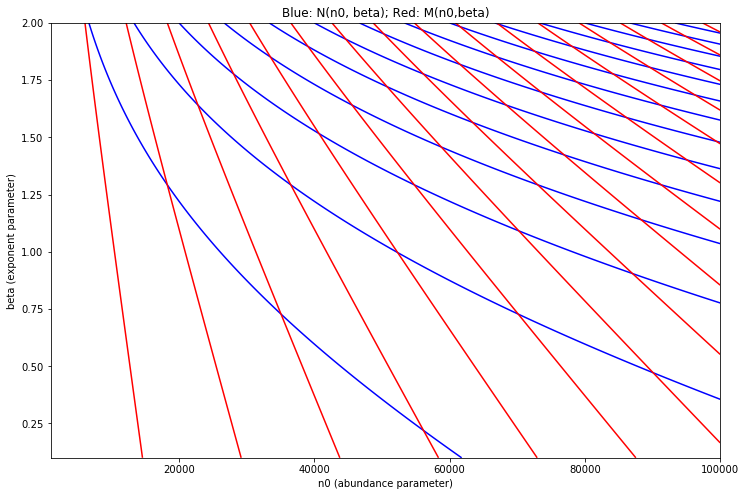

In [5]:
params = {}
params['alpha'] = 2.23
params['xi'] = 10**-4
params['xf'] = 10**-3
params['x0'] = params['xf']
params['cm'] = (10**-1.2)*(params['x0']**params['alpha'])

# beta between 0.1 and 2
beta_vals = np.linspace(0.1, 2, num=191)

# n0 between 1000 and 100000
n0_vals = 10**(np.linspace(3,5,num=201))

# grid for contours
X, Y = np.meshgrid(n0_vals, beta_vals)
plt.rcParams['contour.negative_linestyle'] = 'solid';
plt.contour(X, Y, N(X,Y,**params), 16, colors='b');
plt.contour(X, Y, M(X,Y,**params), 16, colors='r');
plt.title("Blue: N(n0, beta); Red: M(n0,beta)")
plt.xlabel("n0 (abundance parameter)"); plt.ylabel("beta (exponent parameter)");


It does appear as though the mapping from $(n_0, \beta)$ to $(N, M)$ is one to one... so the next step is to determine $n_0(N,M)$ and $\beta(N,M)$. A good place to start is by noting that

$$\begin{array}{r c l}
N(n_0,\beta) & = & n_0 F(\beta)\\
M(n_0,\beta) & = & n_0 G(\beta)
\end{array}$$

Where

$$
F(\beta) = \left\{ \begin{array}{c c}
x_0^\beta \left( \frac{x_f^{1-\beta} \, - \, x_i^{1-\beta}}{1-\beta} \right )& \beta \ne 1\\
x_0(\ln x_f - \ln x_i) & \beta = 1
\end{array}\right.
$$

and

$$
G(\beta) = \left\{ \begin{array}{c c}
C_m x_0^{\beta-\alpha} \left( \frac{x_f^{1+\alpha-\beta} \, - \, x_i^{1+\alpha-\beta}}{1+\alpha-\beta} \right )& \beta \ne \alpha + 1\\
C_m x_0(\ln x_f - \ln x_i) & \beta = \alpha + 1
\end{array}\right.
$$

Given $N(n_0,\beta) = N_1$ and $M(n_0,\beta) = M_1$ it follows that

$$
\frac{M_1}{N_1} = \frac{G(\beta)}{F(\beta)}
$$

which is a function purely of $\beta$; if $G(\beta)/F(\beta)$ is invertible that yields $\beta(N,M)$

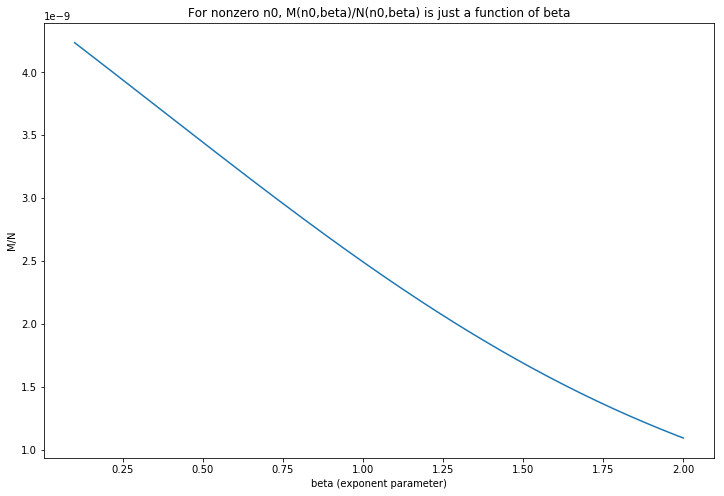

In [6]:
def F(beta):
    return N(1,beta,**params)

def G(beta):
    return M(1,beta,**params)

plt.plot(beta_vals,G(beta_vals)/F(beta_vals));
plt.title("For nonzero n0, M(n0,beta)/N(n0,beta) is just a function of beta");
plt.xlabel("beta (exponent parameter)"); plt.ylabel("M/N");


In fact, $G(\beta)/F(\beta)$ appears nearly linear, so Newton's Method should make quick work of finding $\beta$. And once we know $\beta$ then $n_0$ falls out from either

$N(n_0,\beta)=n_0F(\beta) \Rightarrow n_0=N_1/F(\beta)$

or

$M(n_0,\beta)=n_0G(\beta) \Rightarrow n_0=M_1/G(\beta)$

To test this out with concrete numbers, let's take $n_0=10^4$ and $\beta=1.05$

In [7]:
beta = 1.05
n0 = 10**3
N1 = N(n0,beta,**params)
M1 = M(n0,beta,**params)
del beta, n0

print N1,M1,M1/N1

2.44036908604 5.870358584e-09 2.40552079502e-09


These numbers imply that the bin containing plankton with ESDs in the range of 100 microns to 1000 microns ($x_i$ to $x_f$) has ~2.5 organisms (per unit volume?) and a total mass of ~5.9 micrograms (per unit volume?).

Given these values of $N_1$ and $M_1$, can we recover $\beta = 1.05$ and $n_0 = 10^4$?

In [8]:
def find_beta(beta):
    return G(beta)/F(beta) - M1/N1

beta = optimize.fsolve(find_beta,1)
n0 = N1/F(beta)
print beta, n0
del beta, n0

[ 1.05] [ 1000.]


The above shows we can, the next step (I think) is to write a python script that does the root-finding instead of relying on optimize.fsolve (that is what we will need to translate to Fortran for MARBL); I think that will require defining *F(beta)*, *F'(beta)*, *G(beta)*, and *G'(beta)* explicitly; from the plot above, Newton's method seems like a reasonable way to solve for *beta*

## Implementing Newton's Method

We want to find the root of $H(\beta) = G(\beta)/F(\beta) - M_1/N_1$, which requires finding 

$$
H'(\beta) = \frac{G'(\beta)F(\beta) - F'(\beta)G(\beta)}{F^2(\beta)}
$$

That means we need the analytic form of $F'(\beta)$ and $G'(\beta)$; after lots of algebra, it works out that

$$
F'(\beta) = \left\{ \begin{array}{c c}
\frac{\big((1-\beta) \ln(x_0)+1\big)F(\beta) + x_0^\beta\big(x_i^{1 - \beta} \ln x_i - x_f^{1 - \beta} \ln x_f\big)}{1-\beta} & \beta \ne 1 \\
x_0 F(1) + x_0 \frac{(\ln x_i)^2 - (\ln x_f)^2}{2} & \beta = 1
\end{array}\right.
$$

and

$$
G'(\beta) = \left\{ \begin{array}{c c}
\frac{\big((1+\alpha-\beta) \ln(x_0)+1\big)G(\beta) + C_mx_0^{\beta - \alpha} \big(x_i^{1 + \alpha - \beta} \ln x_i - x_f^{1 + \alpha - \beta} \ln x_f\big)}{1+\alpha-\beta} & \beta \ne \alpha + 1 \\
? & \beta = \alpha + 1
\end{array}\right.
$$

Note that I don't have an analytic form for $G'(\alpha+1)$ yet, but that seems to be outside our expected range of $\beta$ so maybe I can continue to avoid figuring it out.

In [9]:
from scipy import misc

# Analytic F'(beta)
def Fp(beta):
    if (beta != 1):
        return ((((1-beta)*np.log(params['x0'])+1)*F(beta) + 
                (params['x0']**beta) *
                (np.log(params['xi'])*(params['xi']**(1.-beta)) - np.log(params['xf'])*(params['xf']**(1.-beta)))) /
                (1.-beta))
    return np.log(params['x0'])*F(1)+params['x0']*((np.log(params['xi'])**2) -
                                                   (np.log(params['xf'])**2))/2.
vFp = np.vectorize(Fp)

# Python computing F'(beta) numerically
def miscFp(beta):
    return misc.derivative(F, beta, dx=10**-5)
vmiscFp = np.vectorize(miscFp)

# Analytic G'(beta)
def Gp(beta):
    if (beta - params['alpha'] != 1):
        return ((((1+params['alpha']-beta)*np.log(params['x0'])+1)*G(beta) + 
                (params['cm']*params['x0']**(beta-params['alpha'])) *
                (np.log(params['xi'])*(params['xi']**(1.+params['alpha']-beta)) - np.log(params['xf'])*(params['xf']**(1.+params['alpha']-beta)))) /
                (1.+params['alpha']-beta))
    raise Exception("Do not have analytic form for G'(1+alpha)")
vGp = np.vectorize(Gp)

# Python computing F'(beta) numerically
def miscGp(beta):
    return misc.derivative(G, beta, dx=10**-5)
vmiscGp = np.vectorize(miscGp)

# Quotient rule for derivatives
def Hp(beta):
    return (F(beta)*Gp(beta)-G(beta)*Fp(beta))/(F(beta)**2)
vHp = np.vectorize(Hp)

# Python computing derivative of G(beta)/F(beta) numerically
def miscHp(beta):
    return misc.derivative(find_beta, beta, dx=10**-5)
vmiscHp = np.vectorize(miscHp)

print "Max relative error between analytic and numerical derivatives"
print np.max(np.abs(vHp(beta_vals) - vmiscHp(beta_vals)))/np.max(np.abs(vmiscHp(beta_vals)))

if False:
    # Comparisons!
    print Hp(0.5), miscHp(0.5), Hp(0.5) - miscHp(0.5)
    print Hp(1), miscHp(1), Hp(1) - miscHp(1)
    print Hp(1.5), miscHp(1.5), Hp(1.5) - miscHp(1.5)
    print Fp(0.5), miscFp(0.5)
    print Fp(1), miscFp(1)
    print Fp(1.5), miscFp(1.5)
    print np.max(np.abs(vFp(beta_vals) - vmiscFp(beta_vals)))
    print '---'
    print Gp(0.5), miscGp(0.5)
    print Gp(1), miscGp(1)
    print Gp(1.5), miscGp(1.5)
    print Gp(params['alpha']+1), miscGp(params['alpha']+1)
    print np.max(np.abs(vGp(beta_vals) - vmiscGp(beta_vals)))

    plt.plot(beta_vals, vFp(beta_vals))
    plt.plot(beta_vals, vmiscFp(beta_vals));
    plt.semilogy(beta_vals,vFp(beta_vals));
    plt.plot(beta_vals,misc.derivative(F,beta_vals,dx=0.05));
    plt.plot(beta_vals,Fp(beta_vals));


Max relative error between analytic and numerical derivatives
7.16193334665e-08


## Merging two columns

An interesting thought experiment is to see what happens when two columns with different $n(x)$ distributions mix. We parameterize column 1 with $n_0 = 5$ and $\beta = 0.75$, while column 2 is parameterized by $n_0 = 2$ and $\beta = 0.25$. The ESD range for both columns is 1 $\mu$m to 500 $\mu$m.

Average column is parameterized by n0 = 3.4292 and beta = 0.6778


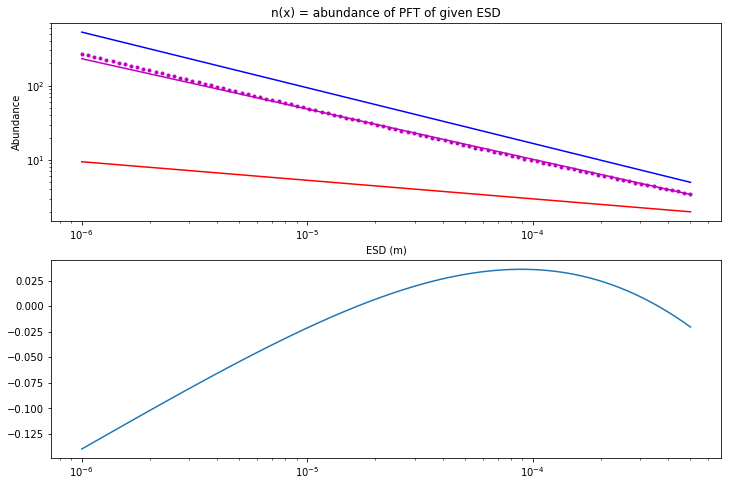

In [10]:
# We want to look at some abundance plots
n = lambda n0,beta,x0: n0*((x/x0)**(-beta))
x = 10**(np.linspace(-6, -3.3, num=100))

# Redefine this function with M/N as input
def find_beta(beta):
    return M(1,beta,**shr_params)/N(1,beta,**shr_params) - MoverN

# Parameters shared by two columns
shr_params = {}
shr_params['alpha'] = 2.23
shr_params['xi'] = 10**-6
shr_params['xf'] = 5*10**-4
shr_params['x0'] = shr_params['xf']
shr_params['cm'] = (10**-1.2)*(shr_params['x0']**shr_params['alpha'])

# Column 1
n01 = 5.
beta1 = 0.75
N1 = N(n01, beta1, **shr_params)
M1 = M(n01, beta1, **shr_params)

# Column 2
n02 = 2.
beta2 = 0.25
N2 = N(n02, beta2, **shr_params)
M2 = M(n02, beta2, **shr_params)

# Average Columns, find new n0, beta
MoverN = (M1 + M2)/(N1 + N2)
beta = optimize.fsolve(find_beta,1)
n0 = 0.5*(N1 + N2)/N(1,beta,**shr_params)
print "Average column is parameterized by n0 = %0.4f and beta = %0.4f" % (n0, beta)

#plt.subplot(2,1,1);
#plt.loglog(x, n(n01, beta1, shr_params['x0']),'-b');
#plt.loglog(x, n(n02, beta2, shr_params['x0']),'-r');
#plt.loglog(x, n(n0, beta, shr_params['x0']),'-m');
#plt.loglog(x, (n(n01, beta1, shr_params['x0'])+n(n02, beta2, shr_params['x0']))/2.,'.m');
#plt.title('n(x) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

#plt.subplot(2,1,2);
#plt.semilogx(x, (n(n0, beta, shr_params['x0'])-(n(n01, beta1, shr_params['x0'])+n(n02, beta2, shr_params['x0']))/2.) /
#                n(n0, beta, shr_params['x0']),'-b');

class1 = lambda x: n(n01, beta1, shr_params['x0'])
class2 = lambda x: n(n02, beta2, shr_params['x0'])
avg_class = lambda x: n(n0, beta, shr_params['x0'])
true_avg = lambda x: 0.5*(class1(x) + class2(x))
rel_err = lambda x: (avg_class(x) - true_avg(x))/true_avg(x)

plt.subplot(2,1,1);
plt.loglog(x, class1(x),'-b');
plt.loglog(x, class2(x),'-r');
plt.loglog(x, avg_class(x),'-m');
plt.loglog(x, true_avg(x),'.m');
plt.title('n(x) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

plt.subplot(2,1,2);
plt.semilogx(x, rel_err(x));



But what happens if we split this into two bins?

Average column is parameterized by n0 = 18.3949 and beta = 0.7213 on first interval
Average column is parameterized by n0 = 3.4655 and beta = 0.6506 on second interval


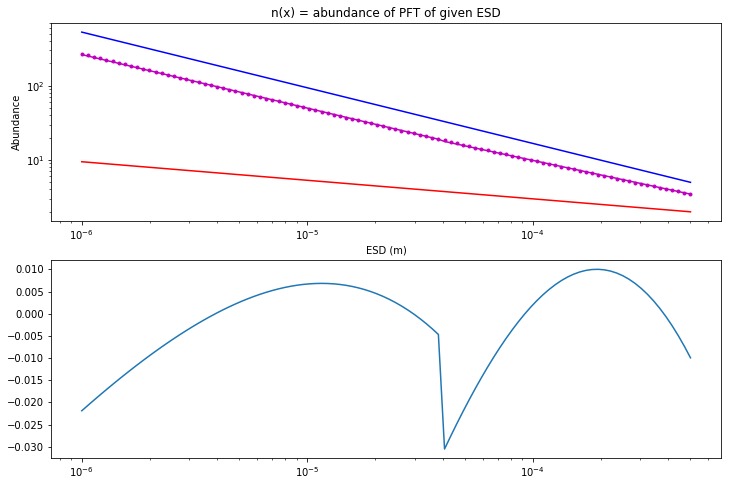

In [11]:
n = lambda n0,beta,x0: n0*((x/x0)**(-beta))
def piecewise_n(x, n0a, n0b, beta_a, beta_b, x0a, x0b, xm):
    outval = np.where(x < xm, n(n0a,beta_a,x0a), n(n0b,beta_b,x0b))
    return outval
#    if (x < xm):
#        return n(n0a,beta,x0a)
#    return n(n0b,beta,x0b)
#vpiecewise_n = np.vectorize(piecewise_n)

# Two size bins: instead of just [xi, xf] look at [xi, xm] and [xm, xf]
xi = 10**-6
xm = 4*10**-5
#xm = 10**-4
xf = 5*10**-4

# parameters for [xi, xm]
shr_params1 = {}
shr_params1['alpha'] = 2.23
shr_params1['xi'] = xi
shr_params1['xf'] = xm
shr_params1['x0'] = shr_params1['xf']
shr_params1['cm'] = (10**-1.2)*(shr_params1['x0']**shr_params1['alpha'])

# parameters for [xm, xf]
shr_params2 = {}
shr_params2['alpha'] = 2.23
shr_params2['xi'] = xm
shr_params2['xf'] = xf
shr_params2['x0'] = shr_params2['xf']
shr_params2['cm'] = (10**-1.2)*(shr_params2['x0']**shr_params2['alpha'])

# Column 1: a => [xi, xm], b => [xm, xf]
n01b = 5.
beta1 = 0.75
x = xm
n01a = n(n01b, beta1, xf)
N1a = N(n01a, beta1, **shr_params1)
M1a = M(n01a, beta1, **shr_params1)
N1b = N(n01b, beta1, **shr_params2)
M1b = M(n01b, beta1, **shr_params2)

# Column 2: a => [xi, xm], b => [xm, xf]
n02b = 2.
beta2 = 0.25
x = xm
n02a = n(n02b, beta2, xf)
N2a = N(n02a, beta2, **shr_params1)
M2a = M(n02a, beta2, **shr_params1)
N2b = N(n02b, beta2, **shr_params2)
M2b = M(n02b, beta2, **shr_params2)

# Average Columns, find new n0, beta
def find_beta_a(beta):
    return M(1,beta,**shr_params1)/N(1,beta,**shr_params1) - MoverNa

def find_beta_b(beta):
    return M(1,beta,**shr_params2)/N(1,beta,**shr_params2) - MoverNb

MoverNa = (M1a + M2a)/(N1a + N2a)
MoverNb = (M1b + M2b)/(N1b + N2b)
beta_a = optimize.fsolve(find_beta_a,1)
n0a = 0.5*(N1a + N2a)/N(1,beta_a,**shr_params1)
beta_b = optimize.fsolve(find_beta_b,1)
n0b = 0.5*(N1b + N2b)/N(1,beta_b,**shr_params2)

print "Average column is parameterized by n0 = %0.4f and beta = %0.4f on first interval" % (n0a, beta_a)
print "Average column is parameterized by n0 = %0.4f and beta = %0.4f on second interval" % (n0b, beta_b)

x = 10**(np.linspace(-6, -3.3, num=100))

class1 = lambda x: piecewise_n(x, n01a, n01b, beta1, beta1, xm, xf, xm)
class2 = lambda x: piecewise_n(x, n02a, n02b, beta2, beta2, xm, xf, xm)
avg_class = lambda x: piecewise_n(x, n0a, n0b, beta_a, beta_b, xm, xf, xm)
true_avg = lambda x: 0.5*(class1(x) + class2(x))
rel_err = lambda x: (avg_class(x) - true_avg(x) )/true_avg(x)

plt.subplot(2,1,1);
plt.loglog(x, class1(x),'-b');
plt.loglog(x, class2(x),'-r');
plt.loglog(x, avg_class(x),'-m');
plt.loglog(x, true_avg(x),'.m');
plt.title('n(x) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

plt.subplot(2,1,2);
plt.semilogx(x, rel_err(x));
